In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from assimilation_schemes import OI

plt.style.use('seaborn')

In [2]:
##### NOT USED ######
def gen_random_normal(mean, var, size, random_state=None):
    """
    Generate random gaussian distribution numbers
    
    Parameters:
    ----------
    mean, var: scaler or array-like.
        If array-like, its length should equal to 'size'.
    size: int
        The amount of random numbers.
    random_state: int
        If None, np.random.randint(0, 99) will be used.
        
    Return:
    ------
    An 1d array of random numbers.
    """
    if random_state is None:
        random_state = np.random.randint(0, 99)
        
    mean = np.array(mean)
    var = np.array(var)
    
    rng = np.random.RandomState(random_state)
    result = rng.randn(max(mean.size, var.size, size))
    result = (result + mean) * np.sqrt(var)
    return result
#####################

def gen_random_obserr(mean, var, size, obs_intv, random_state=None):
    """
    Generate random gaussian observation error.
    
    Parameters:
    ----------
    mean, var: scaler.
        Mean and variance for gaussian distribution.
    size: int.
        The size of output array.
    obs_intv: int.
        The observation interval length in the output array.
    random_state: int.
        Random state. Default is None and it will use np.random.randint.
        
    Return:
    ------
    obs_err: 1-d array.
        The array which observation error occurs every `obs_intv` and others are 0.
        
    EX:
    >>> gen_random_obserr(0, 1, 12, 4)
    array([-0.34889445,  0,  0,  0,  0.98370343,  0,  0,  0,
           0.58092283,  0,  0,  0])
    """
    if random_state is None:
        random_state = np.random.randint(0, 50)
    
    length = np.ceil(size/obs_intv) * obs_intv
    obs_err = np.zeros(int(length)).reshape((-1,obs_intv))
    
    rng = np.random.RandomState(random_state)
    obs_err[:,0] = rng.normal(mean, np.sqrt(var), size=obs_err.shape[0])
    obs_err = obs_err.ravel()[:size]
    return obs_err


def lorenz63_fdm(x0, ts, sigma=None, r=None, b=None):
    """Solve lorenz63 with finit difference method"""  
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    size = ts.size
    dt = ts[1] - ts[0]
    
    x = np.zeros((size,))
    y = np.zeros((size,))
    z = np.zeros((size,))
    x[0] = x0[0]
    y[0] = x0[1]
    z[0] = x0[2]
    
    for i in range(1, size):
        x[i] = x[i-1] + sigma * (y[i-1] - x[i-1]) * dt
        y[i] = y[i-1] + (r*x[i-1] - y[i-1] - x[i-1]*z[i-1]) * dt
        z[i] = z[i-1] + (x[i-1]*y[i-1] - b*z[i-1]) * dt
    
    return np.vstack((x, y, z))


def M(xi, yi, zi, dt, sigma=None, r=None, b=None):
    """tangent linear model for lorenz63_fdm"""
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    M = np.array([
        [1-sigma*dt, sigma*dt, 0],
        [r*dt-zi*dt, 1-dt, -xi*dt],
        [yi*dt, xi*dt, 1-b*dt]
    ])
    return M


def stability_index_lorenz63(x, y, z, sigma=None, r=None, b=None):
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
        
    M = np.array([
        [-sigma, sigma, 0],
        [r-z, -1, -x],
        [y, x, -b]
    ])
    
    eigv, P = np.linalg.eig(M)
    r = eigv.real
    if np.all(r<0):
        # stable case
        return r.sum()
    else:
        # unstable case
        r[r<0] = 0
        return r.sum()

In [3]:
time = 16
dt = 0.01
ts = np.arange(0, time, dt)
X0 = np.array([[8, 0, 30]]).T
X_nature = lorenz63_fdm(X0.ravel(), ts)

In [4]:
# observation parameters for each variables
obs_mean = [0, 0, 0]
obs_var = [2, 2, 2] 
random_state = [20, 21, 22]

# assimilate observation parameters
obs_timeintv = 0.08
obs_intv = int(obs_timeintv / dt)
cycle_num = int(time / obs_timeintv)

# construct observation error
size = int(time/dt)
X_obs_err = np.zeros((3, size))
for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
    X_obs_err[irow,:] = gen_random_obserr(obsm, obsv, size, obs_intv, rst)
    
X_obs = X_nature + X_obs_err
X_obs = X_obs[:,::obs_intv]

In [5]:
X_ini = X_nature[:,[0]] + np.array([[50], [40], [60]])

In [6]:
def plot_assim_result(result, X_nature, X_obs, rmse, stableidx, result_label=None):
    # plot assimilation result
    ts = np.arange(0, time, dt)
    t_obs = np.arange(0, time, obs_timeintv)

    # plot nature run and assimilation result
    fig, axs = plt.subplots(nrows=4, figsize=(20, 12))
    for i in range(3):
        axs[i].plot(ts, result[i,:], label=result_label)
        axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
        axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
    # plot RMSE and stable index
    axs[3].plot(ts, rmse, c='grey', lw=0.8)
    bool_idx = stableidx > 0
    axs[3].scatter(ts[~bool_idx], rmse[~bool_idx], s=20, c='white')
    axs[3].scatter(ts[bool_idx], rmse[bool_idx], s=20, c=stableidx[bool_idx], cmap='Reds')
    axs[3].scatter(ts[::int(obs_timeintv/dt)], rmse[::int(obs_timeintv/dt)], s=5, marker='x')

    axs[0].set_title('X')
    axs[1].set_title('Y')
    axs[2].set_title('Z')
    axs[3].set_title('RMSE and instability')
    axs[3].set_xlabel('time')

    axs[0].legend()
    plt.tight_layout()
    return fig, axs

### EKF

In [119]:
# from iterative NMC in test2
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])
Pb *= 0.2
#Pb = R * 1.1

R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)


print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value for experiment: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')

alpha = 0.3   # relaxation
inflat = 1.5

cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    # calculate analysis field, then forecast
    xa, Pa = OI(xb, X_obs[:,[nc]], Pb, R)
    x = lorenz63_fdm(xa.ravel(), ts)
    result[:,nc*int(cycle_len/dt):(nc+1)*int(cycle_len/dt)] = x
        
    # for next cycle
    Pb = alpha * Pb + (1-alpha) * M(xb[0,0], xb[1,0], xb[2,0], dt) @ Pa @ M(xb[0,0], xb[1,0], xb[2,0], dt).T
    Pb *= inflat
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)

========Some Parameters=========
cycle length (time interval between two observations): 0.08 sec
number of cycle: 200
dt = 0.01 sec
initial value for experiment: [58. 40. 90.]
initial value for nature run: [ 8.  0. 30.]


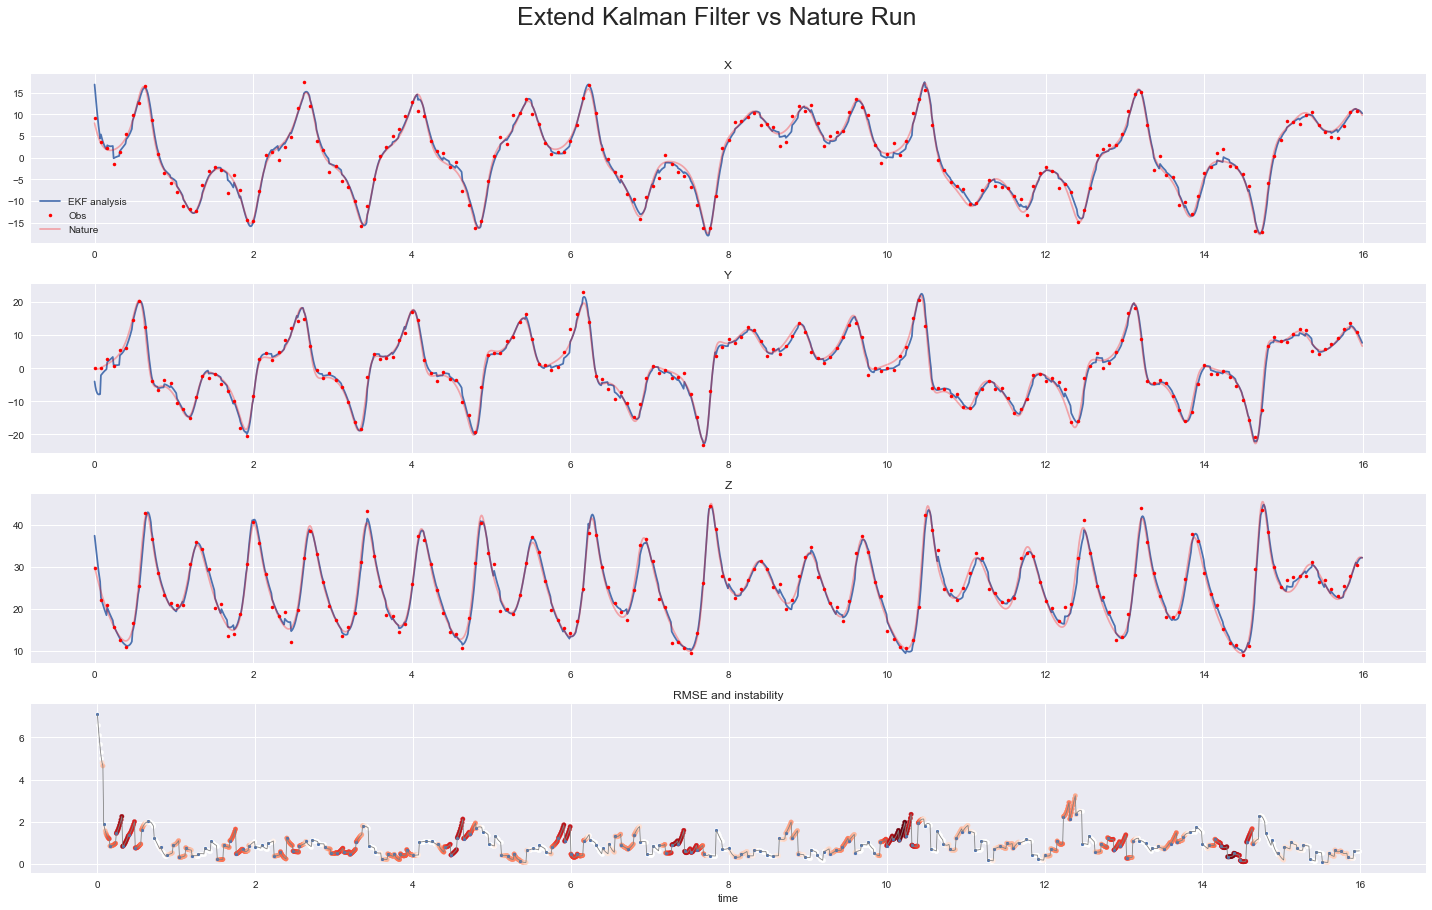

In [120]:
# calculate RMSE and stable index
rmse_ekf = np.sqrt(np.mean((result-X_nature)**2, axis=0))
stableidx = []
for x in result.T:
    stableidx.append(stability_index_lorenz63(*x))
stableidx = np.array(stableidx)

# plot
fig, axs = plot_assim_result(result, X_nature, X_obs, rmse_ekf, stableidx, 'EKF analysis')
fig.suptitle('Extend Kalman Filter vs Nature Run', fontsize=25, y=1.05);

In [121]:
rmse_ekf.mean()

0.9096324248899711

### OI

In [123]:
# from iterative NMC in test2
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])
Pb *= 0.2

R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)


print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value for experiment: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')

alpha = 0  # relaxation

cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    # calculate analysis field, then forecast
    xa, Pa = OI(xb, X_obs[:,[nc]], Pb, R)
    x = lorenz63_fdm(xa.ravel(), ts)
    result[:,nc*int(cycle_len/dt):(nc+1)*int(cycle_len/dt)] = x
        
    # for next cycle
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)

========Some Parameters=========
cycle length (time interval between two observations): 0.08 sec
number of cycle: 200
dt = 0.01 sec
initial value for experiment: [58. 40. 90.]
initial value for nature run: [ 8.  0. 30.]


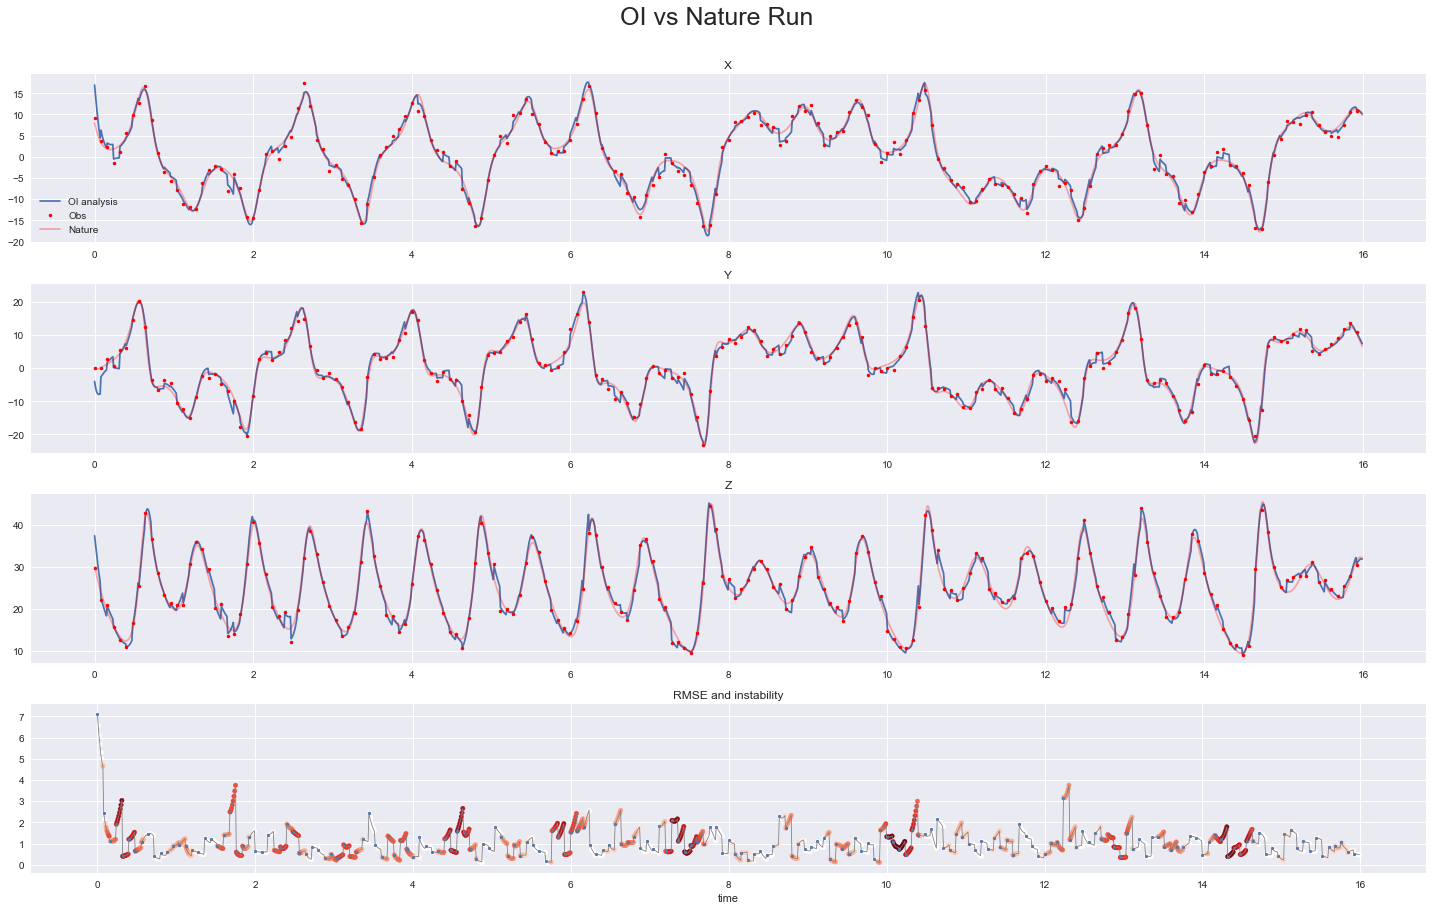

In [124]:
# calculate RMSE and stable index
rmse_oi = np.sqrt(np.mean((result-X_nature)**2, axis=0))
stableidx = []
for x in result.T:
    stableidx.append(stability_index_lorenz63(*x))
stableidx = np.array(stableidx)

# plot
fig, axs = plot_assim_result(result, X_nature, X_obs, rmse_oi, stableidx, 'OI analysis')
fig.suptitle('OI vs Nature Run', fontsize=25, y=1.05);

In [125]:
rmse_oi.mean()

1.0219821361085586

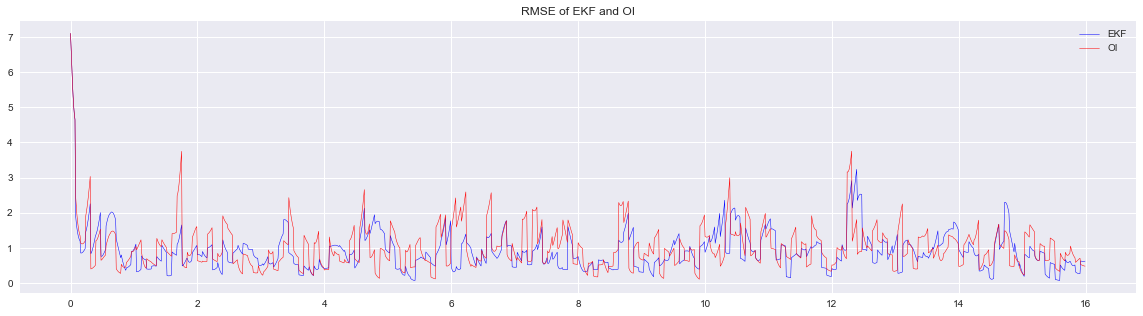

In [126]:
# compare two rmse
ts = np.arange(0, time, dt)

plt.figure(figsize=(20, 5))
plt.plot(ts, rmse_ekf, c='blue', lw=0.5, label='EKF')
plt.plot(ts, rmse_oi, c='red', lw=0.5, label='OI')
plt.legend()
plt.title('RMSE of EKF and OI');

### 3D Var

In [127]:
from scipy.optimize import minimize

def _3dvar_costfunction(x, xb, yo, invPb, invR, H_func=None, H=None):
    """
    x and xb is 1d array with shape (n,), the other is 2d matrix
    """
    x = x[:,np.newaxis]
    xb = xb[:,np.newaxis]
    
    if H_func is None:
        innovation = yo - x
    else:
        innovation = yo - H_func(x) 
        
    return 0.5 * (xb-x).T @ invPb @ (xb-x) + 0.5 * innovation.T @ invR @ innovation

def m3dvar(xb, yo, Pb, R, H_func=None, H=None):    
    if H_func is None:
        innovation = yo - xb
    else:
        innovation = yo - H_func(xb)
        
    invPb = np.linalg.inv(Pb)
    invR = np.linalg.inv(R)
    cost_func = lambda x: _3dvar_costfunction(x, xb.ravel(), yo, invPb, invR)
    
    return minimize(cost_func, xb.ravel(), method='BFGS').x

In [128]:
# from iterative NMC in test2
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])
Pb *= 0.2

R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)


print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value for experiment: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')

alpha = 0  # relaxation

cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    # calculate analysis field, then forecast
    xa = m3dvar(xb, X_obs[:,[nc]], Pb, R)
    x = lorenz63_fdm(xa.ravel(), ts)
    result[:,nc*int(cycle_len/dt):(nc+1)*int(cycle_len/dt)] = x
        
    # for next cycle
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)

========Some Parameters=========
cycle length (time interval between two observations): 0.08 sec
number of cycle: 200
dt = 0.01 sec
initial value for experiment: [58. 40. 90.]
initial value for nature run: [ 8.  0. 30.]


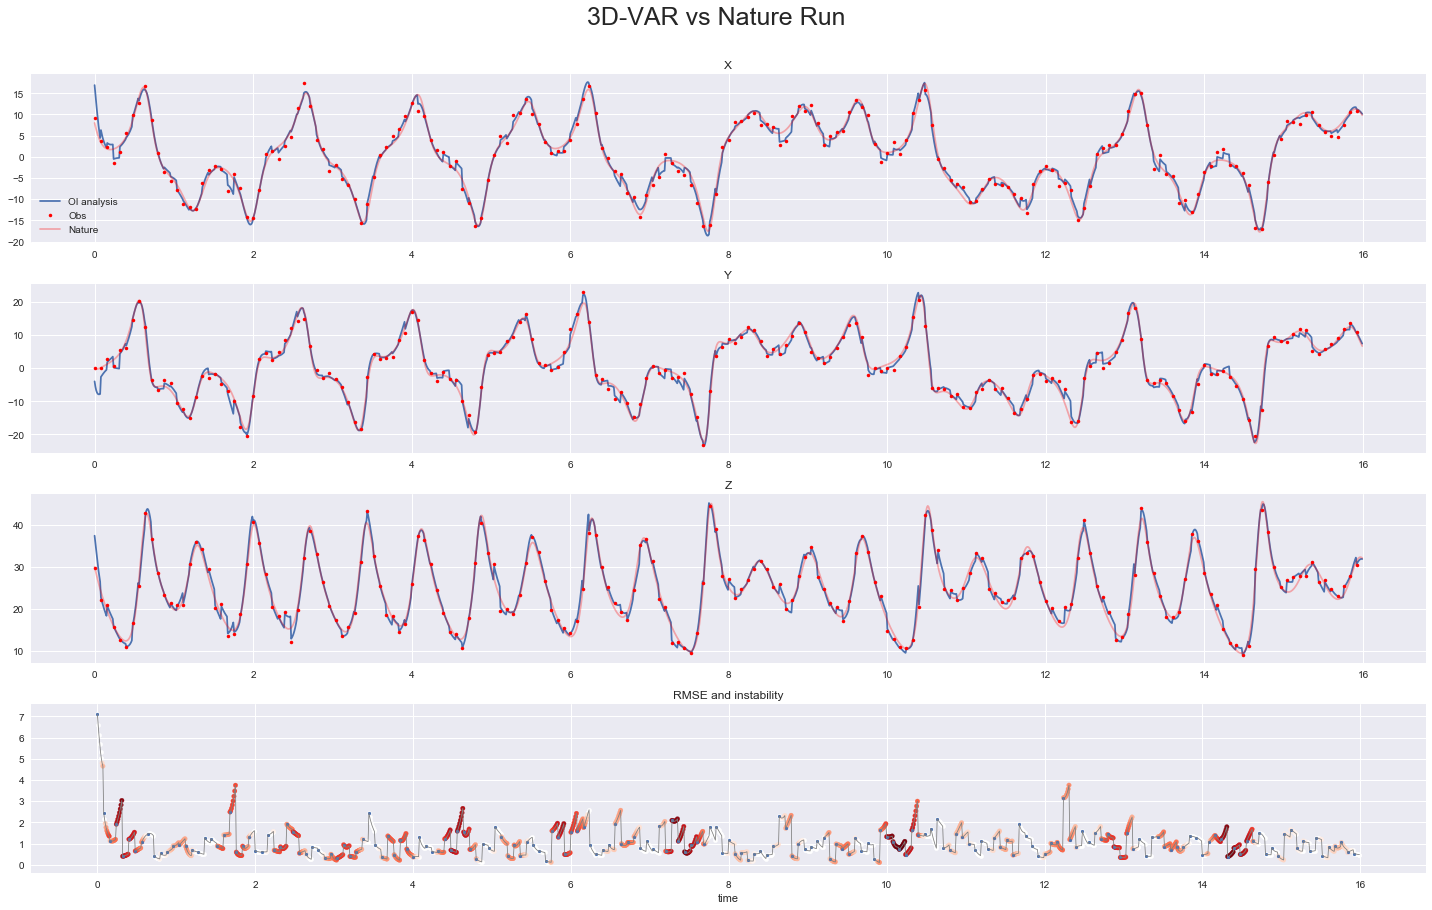

In [129]:
# calculate RMSE and stable index
rmse_3dvar = np.sqrt(np.mean((result-X_nature)**2, axis=0))
stableidx = []
for x in result.T:
    stableidx.append(stability_index_lorenz63(*x))
stableidx = np.array(stableidx)

# plot
fig, axs = plot_assim_result(result, X_nature, X_obs, rmse_3dvar, stableidx, 'OI analysis')
fig.suptitle('3D-VAR vs Nature Run', fontsize=25, y=1.05);

In [130]:
rmse_3dvar.mean()

1.0219821268265465

### EnKF

In [274]:
# from iterative NMC in test2
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])
Pb *= 0.2

R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)

N_ens = 30

# generate ensemble
X_ens_ini = np.random.multivariate_normal(X_nature[:,0], Pb, size=N_ens).T  # (3, N_ens)
X_ens_ini += 5

ts = np.arange(0, time, dt)
result_ens = np.zeros((N_ens,3,ts.size))
for iens in range(N_ens):
    x0 = X_ens_ini[:,iens]
    result_ens[iens] = lorenz63_fdm(x0, ts)

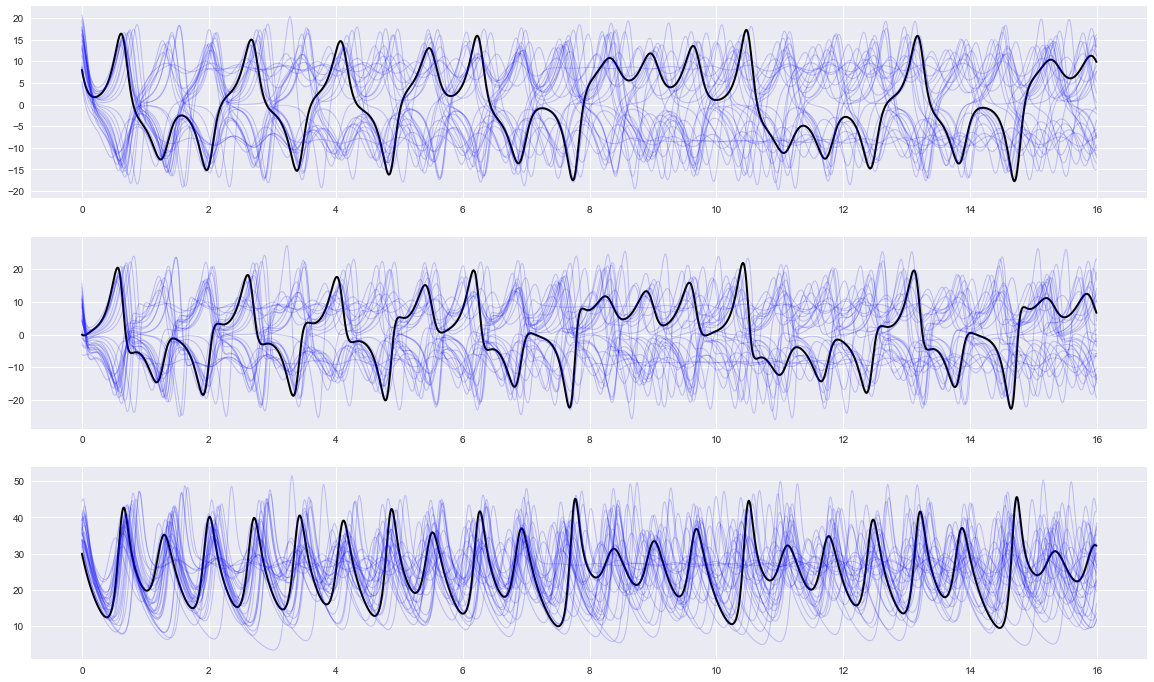

In [275]:
### before assimilation

fig, axs = plt.subplots(figsize=(20, 12), nrows=3)
axs[0].plot(ts, X_nature[0,:], 'k', lw=2)
axs[1].plot(ts, X_nature[1,:], 'k', lw=2)
axs[2].plot(ts, X_nature[2,:], 'k', lw=2)

for iens in range(N_ens):
    axs[0].plot(ts, result_ens[iens,0,:], 'blue', alpha=0.2, lw=1)
    axs[1].plot(ts, result_ens[iens,1,:], 'blue', alpha=0.2, lw=1)
    axs[2].plot(ts, result_ens[iens,2,:], 'blue', alpha=0.2, lw=1)

In [276]:
def EnKF(xb, yo, Pb, R, H_func=None, H=None):
    """xb: (3, 30) -> (n_dim, n_ens)"""
    if H_func is None:
        H_func = lambda arr: arr
    if H is None:
        H = np.ones_like(R)
        
    N_ens = xb.shape[1]
    yo_ens = np.random.multivariate_normal(yo.ravel(), R, size=N_ens).T  # (ndim_yo, N_ens)
    xb_mean = xb.mean(axis=1)[:,np.newaxis]  # (ndim_xb, 1)
    
    xa_ens = np.zeros((xb.shape[0], N_ens))
    for iens in range(N_ens):
        xb_mean = xb.mean(axis=1)[:,np.newaxis]
        Xb_perturb = xb - xb_mean
        HXb_perturb = H_func(Xb_perturb) - H_func(Xb_perturb).mean(axis=1)[:,np.newaxis]
        
        PfH_T = Xb_perturb @ HXb_perturb.T / (N_ens-1)
        HPfH_T = HXb_perturb @ HXb_perturb.T / (N_ens-1)
        K = PfH_T @ np.linalg.inv(HPfH_T + R)
        xa_ens[:,[iens]] = xb[:,[iens]] + K @ (yo_ens[:,[iens]] - H_func(xb[:,[iens]]))
        
    return xa_ens

In [277]:
X_ens_ini.shape

(3, 30)

In [278]:
print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value for experiment: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')

alpha = 0.3   # relaxation
inflat = 1.5

cycle_len = obs_timeintv
result = np.zeros((X_ens_ini.shape[0], X_ens_ini.shape[1], int(cycle_len*cycle_num/dt)))
xb = X_ens_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    # estimate Pb
    Pb = alpha * Pb + (1-alpha) * np.cov(xb)
    Pb *= inflat
    
    # inflat
    xb_perturb = xb - xb.mean(axis=1)[:,np.newaxis]
    xb_perturb *= inflat
    xb = xb.mean(axis=1)[:,np.newaxis] + xb_perturb
    
    # calculate analysis field
    xa = EnKF(xb, X_obs[:,[nc]], Pb, R)
    
    # relaxation
    xb_perturb = xb - xb.mean(axis=1)[:,np.newaxis]
    xa_perturb = xa - xa.mean(axis=1)[:,np.newaxis]
    xa_perturb = (1-alpha) * xa_perturb + alpha * xb_perturb
    xa = xa.mean(axis=1)[:,np.newaxis] + xa_perturb
    
    # ensemble forecast
    for iens in range(N_ens):
        x = lorenz63_fdm(xa[:,iens], ts)  # (ndim, ts.size)
        result[:,iens,nc*int(cycle_len/dt):(nc+1)*int(cycle_len/dt)] = x
        xb[:,iens] = x[:,-1]
        
    # for next cycle
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)

========Some Parameters=========
cycle length (time interval between two observations): 0.08 sec
number of cycle: 200
dt = 0.01 sec
initial value for experiment: [58. 40. 90.]
initial value for nature run: [ 8.  0. 30.]


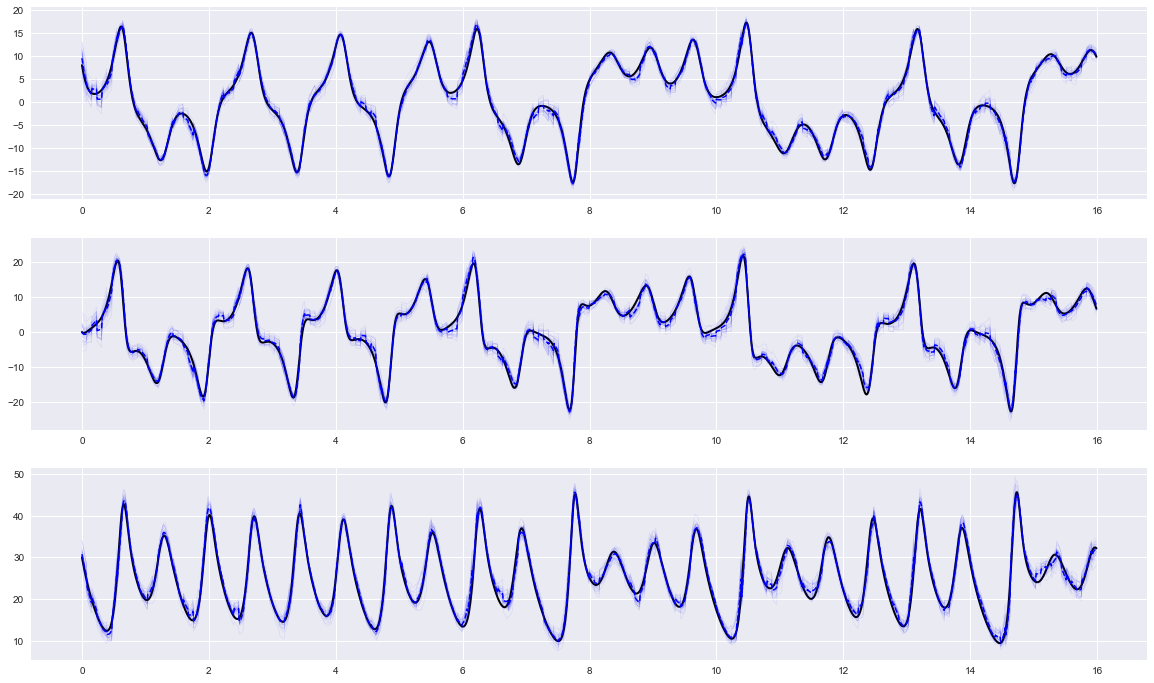

In [279]:
ts = np.arange(0, time, dt)

fig, axs = plt.subplots(figsize=(20, 12), nrows=3)
axs[0].plot(ts, X_nature[0,:], 'k', lw=2)
axs[1].plot(ts, X_nature[1,:], 'k', lw=2)
axs[2].plot(ts, X_nature[2,:], 'k', lw=2)

for iens in range(N_ens):
    axs[0].plot(ts, result[0,iens,:], 'blue', alpha=0.1, lw=0.5)
    axs[1].plot(ts, result[1,iens,:], 'blue', alpha=0.1, lw=0.5)
    axs[2].plot(ts, result[2,iens,:], 'blue', alpha=0.1, lw=0.5)
    
result_ensmean = result.mean(axis=1)
axs[0].plot(ts, result_ensmean[0,:], 'blue', ls='dashed', lw=1.5)
axs[1].plot(ts, result_ensmean[1,:], 'blue', ls='dashed', lw=1.5)
axs[2].plot(ts, result_ensmean[2,:], 'blue', ls='dashed', lw=1.5)

In [280]:
rmse_enkf = np.sqrt(np.mean((result_ensmean-X_nature)**2, axis=0))
rmse_enkf.mean()

0.7936728618834169

In [257]:
alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
inflats = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3]

for alpha in alphas:
    for inflat in inflats:
        cycle_len = obs_timeintv
        result = np.zeros((X_ens_ini.shape[0], X_ens_ini.shape[1], int(cycle_len*cycle_num/dt)))
        xb = X_ens_ini
        t_start = 0
        ts = np.arange(t_start, cycle_len, dt)

        # start cycle assimilation
        for nc in range(cycle_num):
            # estimate Pb
            Pb = alpha * Pb + (1-alpha) * np.cov(xb)
            Pb *= inflat

            # inflat
            xb_perturb = xb - xb.mean(axis=1)[:,np.newaxis]
            xb_perturb *= inflat
            xb = xb.mean(axis=1)[:,np.newaxis] + xb_perturb

            # calculate analysis field
            xa = EnKF(xb, X_obs[:,[nc]], Pb, R)

            # relaxation
            xb_perturb = xb - xb.mean(axis=1)[:,np.newaxis]
            xa_perturb = xa - xa.mean(axis=1)[:,np.newaxis]
            xa_perturb = (1-alpha) * xa_perturb + alpha * xb_perturb
            xa = xa.mean(axis=1)[:,np.newaxis] + xa_perturb

            # ensemble forecast
            for iens in range(N_ens):
                x = lorenz63_fdm(xa[:,iens], ts)  # (ndim, ts.size)
                result[:,iens,nc*int(cycle_len/dt):(nc+1)*int(cycle_len/dt)] = x
                xb[:,iens] = x[:,-1]

            # for next cycle
            t_start = int(ts[-1] + dt)
            ts = np.arange(t_start, t_start+cycle_len, dt)
            
        result_ensmean = result.mean(axis=1)
        rmse_enkf = np.sqrt(np.mean((result_ensmean-X_nature)**2, axis=0))
        print(alpha, inflat, rmse_enkf.mean())

0 1 6.49575014299309
0 1.1 1.32699369278281
0 1.2 1.08483694220683
0 1.3 0.9241072338657773
0 1.4 0.8148537926093214
0 1.5 0.8001855315927022
0 1.6 0.8073533890746399
0 1.7 0.8048966504913139
0 1.8 0.8147810729836426
0 1.9 0.8175706356606104
0 2 0.8179805687951397
0 2.1 0.8442104826958855
0 2.2 0.8513343285390795
0 2.3 0.8796199405369662
0.1 1 5.900853401029332
0.1 1.1 1.3959982241988909
0.1 1.2 1.0342572489184667
0.1 1.3 0.9564065000233464
0.1 1.4 0.8172507069170359
0.1 1.5 0.8101866476289882
0.1 1.6 0.7861835802329525
0.1 1.7 0.7999703640809305
0.1 1.8 0.799033912182528
0.1 1.9 0.8270106914600984
0.1 2 0.8507977105958584
0.1 2.1 0.8725243775784861
0.1 2.2 0.8677964624468953
0.1 2.3 0.8878853048943103
0.2 1 6.483885520630394
0.2 1.1 1.4196394999233866
0.2 1.2 1.0415656949433534
0.2 1.3 0.884476641491685
0.2 1.4 0.8256913310379335
0.2 1.5 0.7975066164459367
0.2 1.6 0.7920915909844513
0.2 1.7 0.8109687681907419
0.2 1.8 0.8221077209258475
0.2 1.9 0.8431471871407428
0.2 2 0.87003825174937

C:\Users\dog\Anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in double_scalars
C:\Users\dog\Anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: overflow encountered in double_scalars
C:\Users\dog\Anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\dog\Anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\dog\Anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square


0.5 1.9 nan


C:\Users\dog\Anaconda3\envs\work\lib\site-packages\numpy\core\_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


0.5 2 nan
0.5 2.1 nan


C:\Users\dog\Anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in matmul
C:\Users\dog\Anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in matmul
C:\Users\dog\Anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in matmul


0.5 2.2 nan
0.5 2.3 nan
0.6 1 1.9899134496347477
0.6 1.1 0.8674237341014348
0.6 1.2 0.8435215285512517
0.6 1.3 0.9155585622891735
0.6 1.4 1.143887622240483
0.6 1.5 1.7446090755208126
0.6 1.6 nan


C:\Users\dog\Anaconda3\envs\work\lib\site-packages\numpy\lib\function_base.py:2445: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\dog\Anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in subtract
C:\Users\dog\Anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in add


0.6 1.7 nan
0.6 1.8 nan
0.6 1.9 nan
0.6 2 nan
0.6 2.1 nan
0.6 2.2 nan
0.6 2.3 nan
0.7 1 1.2540021639985064
0.7 1.1 0.881078146005562
0.7 1.2 1.015822973489632
0.7 1.3 1.920264378541337
0.7 1.4 nan
0.7 1.5 nan
0.7 1.6 nan
0.7 1.7 nan
0.7 1.8 nan
0.7 1.9 nan
0.7 2 nan
0.7 2.1 nan
0.7 2.2 nan
0.7 2.3 nan
0.8 1 0.9861130502556845
0.8 1.1 1.12819665572092
0.8 1.2 nan
0.8 1.3 nan
0.8 1.4 nan
0.8 1.5 nan
0.8 1.6 nan
0.8 1.7 nan
0.8 1.8 nan
0.8 1.9 nan
0.8 2 nan
0.8 2.1 nan
0.8 2.2 nan
0.8 2.3 nan
0.9 1 1.1413757245747542
0.9 1.1 nan
0.9 1.2 nan
0.9 1.3 nan
0.9 1.4 nan
0.9 1.5 nan
0.9 1.6 nan
0.9 1.7 nan
0.9 1.8 nan
0.9 1.9 nan
0.9 2 nan
0.9 2.1 nan
0.9 2.2 nan
0.9 2.3 nan
